In [ ]:
#plt.style.use("dark_background")
#plt.style.use("default")

In [6]:
%run Function_Master.ipynb

**Generating Initial Conditions**

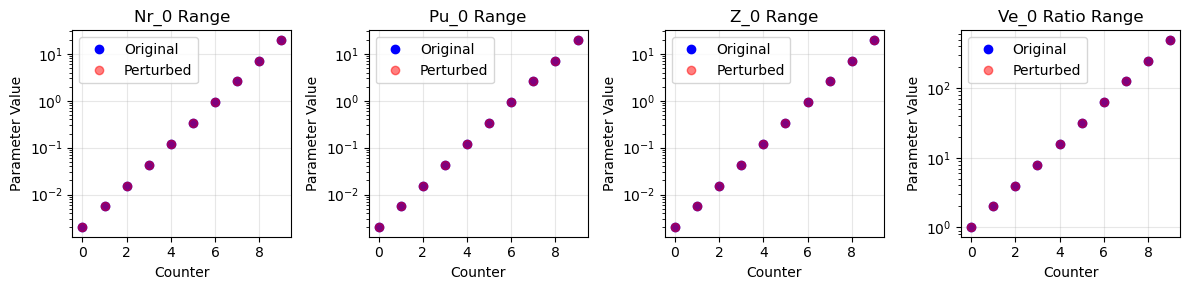

In [2]:
#Randomly perturbed points defining initial conditions

#Define initial ranges on logarithmic scaling since 
#we require more detail at smaller nutrient levels
points = 10

#Log spacing to increase densitiy at smaller values
N_r_range = np.logspace(-3, 1, points) * 2
P_U_range = np.logspace(-3, 1, points) * 2
Z_range   = np.logspace(-3, 1, points) * 2
V_E_ratio = np.geomspace(1, 500, points)

ranges = [N_r_range, P_U_range, Z_range, V_E_ratio]
range_names = ["Nr_0", "Pu_0", "Z_0", "Ve_0 Ratio"]

perturbed_ranges = perturb_range(ranges, range_names, pprint=True, perturb=False)

In [3]:
#Parameterization

alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3

V_ind     = 4e5        # NT per individual virus, Table S1
S_ind     = 1.42e8     # NT per individual host, Table S1

V_max     = 1.4              # Host growth rate
γ_Z       = .4               # Growth rate / Assimilation frequency 
φ         = 3.5e-10 / beta   # Viral adsorption rate, m^3 / (mmol * day)
g         = 1.4              # d^-1 Maximum specific grazing rate

ν_x       = V_ind / (V_ind + S_ind) # Proportion of nutrients originating 
                                    # from virus in host-virus pair
    
λ_P       = .05        # Mortality & Respiration rate
λ_Z       = .05        # d^-1, Linear mortality & respiration & egestion
λ_Z_hat   = 0.1         # Quadratic mortality & respiration & egestion
λ_E       = .3         # Extracellular virus mortality 
δ         = .45        # Host lysis rate

μ_V       = .5         # Max host NT recycling rate 
μ_V_prime = 1.6        # Max de novo NT synthesis rate
μ_u       = 0
μ_r       = 0          # Viral assimilation fraction related to host mortality
μ_s       = 1
μ_P       = .4         # Remineralization fraction due to mortality
μ_delta   = .4         # ARBITRARY VALUE: Remineralization fraction due to lysis
μ_g       = .4         # Remineralization fraction due to sloppy-eating
μ_Z       = .4         # Remineralization fraction due to grazer mortality

K_N       = .1         # mmol m^-3 # Half-saturation constant for nutrient limitation
K_I       = 1          # Half-saturation for light limitation
K_h       = 1          # Half-saturation for ... ?
K_P       = 2.8        # mmol m^-3, Half-saturation constant for grazing of P
I_0       = (np.e - 1) # Compensation irradiance

ω         = 0 # Entraintment term

param_labels = ['V_max', 'γ_Z', 'φ', 'g', 'ν_x', 'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 
                'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 'μ_P', 'μ_delta', 
                'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0', 'ω']

param = [V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω]

In [7]:


print_paramterization(param)

╒════════════════════════════════════════╤═══════════════╤═════════════════╤═══════════════╤══════════════════════╕
│ V_max = 1.4                            │ λ_P = 0.05    │ μ_V = 0.5       │ μ_P = 0.4     │ K_I = 1              │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ γ_Z = 0.4                              │ λ_Z = 0.05    │ μ_V_prime = 1.6 │ μ_delta = 0.4 │ K_h = 1              │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ φ = 3.5e-10 / beta = 110236.2205       │ λ_Z_hat = 0.1 │ μ_u = 0         │ μ_g = 0.4     │ K_P = 2.8            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ g = 1.4                                │ λ_E = 0.3     │ μ_r = 0         │ μ_Z = 0.4     │ I_0 = e - 1 = 1.7183 │
├────────────────────────────────────────┼───────────────┼──────────────

In [5]:
#Generating solution sets
sols = []
t_span = 350

#Remaining state variables usually initiated at the same level (non-random)
Nn_0 = 0.
Pi_0 = 1e-7
Vi_0 = 1e-7

count = 0 #count how many solutions meet qualifications
#i.e. the total nutrients held within the system, defined by the sum of the
#initial values of all state variables must stay below 

NT_cap = 20

max_step   = .1
method     = 'LSODA'
tolerances = [1e-8, 1e-8, 1e-12, 1e-8, 1e-8, 1e-10, 1e-10]
    
#Same order of combinations at a nested for loop
combos = list(product(N_r_range, P_U_range, Z_range, V_E_ratio))

In [10]:
%%time

for Nr_0, Pu_0, Z_0, r in combos:
                
    Ve_0 = est_viral_abund(r, Pu_0, alpha, beta, S_ind, V_ind)

    z0 = [Nn_0, Nr_0, Pu_0, Pi_0, Z_0, Vi_0, Ve_0]
    
    if sum(z0) > NT_cap: #if the sum of the initial conditions are
        continue         #greater than the maximum allowable totalN,
                         #then move to next combination
    count += 1
    solution = solve_ivp(model, [0, t_span], z0, args=param, max_step=max_step, 
                         method=method, atol=tolerances)     
    
    #returns list of initial conditions + solution object
    sols.append((z0, solution))
                
count

CPU times: user 2min 54s, sys: 3.52 s, total: 2min 57s
Wall time: 2min 58s


14560

In [11]:
def sort_sols_by_NT(sols):
    # create a new list of tuples where the first element is the sum of each tuple and the second element is the original tuple
    sum_tuples = [(sum(z0), z0, sol) for z0, sol in sols]
    # sort the new list based on the first element (the sum)
    sorted_sum_tuples = sorted(sum_tuples, key=itemgetter(0))
    # extract and return only the original tuples from the sorted list
    return [(z0, sol) for Tn, z0, sol in sorted_sum_tuples]

sols = sort_sols_by_NT(sols)

In [12]:
%store sols

Stored 'sols' (list)


In [ ]:
 %store -r sols

**Various visualization schemes**

In [ ]:
# Plotting all solutions for each state variable to determine 
# where steady states lie based on initial conditions

%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(25, 10))
fig.subplots_adjust(bottom=0.3, wspace=0.5)

for i, (z0, solution) in enumerate(sols):

    axs[0][0].plot(solution.t, solution.y[1])
    axs[0][0].set_ylabel(r'N_r mmol N / $m^3$', fontsize=12)
    
    axs[0][1].plot(solution.t, solution.y[2])
    axs[0][1].set_ylabel(r'P_U mmol N / $m^3$', fontsize=12)
    
    axs[0][2].plot(solution.t, solution.y[3])
    axs[0][2].set_ylabel(r'P_I mmol N / $m^3$', fontsize=12)
    
    axs[1][0].plot(solution.t, solution.y[4])
    axs[1][0].set_ylabel(r'Z mmol N / $m^3$', fontsize=12)
    
    axs[1][1].plot(solution.t, solution.y[5], label = f"N_T = {sum(z0):<10.3} z0 = {z0}")
    axs[1][1].set_ylabel(r'V_I mmol N / $m^3$', fontsize=12)
    
    axs[1][2].plot(solution.t, solution.y[6])
    axs[1][2].set_ylabel(r'V_E mmol N / $m^3$', fontsize=12)
    
for ax in axs:
    for subax in ax:
        subax.grid(alpha=.3)
        subax.set_xlabel('Time (days)', fontsize=12)
        subax.set_yscale('log')
        
# axs[0][0].set_ylim(1e-5, 10) 
# axs[0][1].set_ylim(1e-12, 10) 
# axs[0][2].set_ylim(1e-8, 10) 
# axs[1][0].set_ylim(1e-12, 10) 
# axs[1][1].set_ylim(1e-12, 1) 
# axs[1][2].set_ylim(1e-12, 10) 

plt.tight_layout()
#axs[0][1].set_ylim(1e-10, 1e2)
#axs[1][1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3))


In [ ]:
#Plotting solutions for each state variable depending on total N
%matplotlib inline

colors = ['darkgoldenrod', 'goldenrod', 'gold', "palegoldenrod", 'slategrey',
         'paleturquoise', 'cornflowerblue', 'royalblue', 'mediumblue', 'darkblue']

names = ['N_n', 'N_r', 'P_U', 'P_I', 'Z', 'V_I', 'V_E']

for k in range(1, 7):
    
    count0, count5, count10, count15, count20 = 0, 0, 0, 0, 0
    
    fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(25, 5))
    
    for i, (z0, solution) in enumerate(sols):
        
        if sum(z0) < 5:
            axs[0].plot(solution.t, solution.y[k])
            axs[0].set_xlabel('Time (days)', fontsize=12)
            axs[0].set_ylabel(f'{names[k]} mmol N / m^3', fontsize=14)
            axs[0].set_title(f'N_T < 5   Solution Count: {count0}', fontsize=12)
            count0 += 1

        elif (sum(z0) >= 5) and (sum(z0) < 10):
            axs[1].plot(solution.t, solution.y[k])
            axs[1].set_xlabel('Time (days)', fontsize=12)
            axs[1].set_ylabel(f'{names[k]} mmol N / m^3', fontsize=14)
            axs[1].set_title(f'5 <= N_T < 10    Solution Count: {count5}', fontsize=12)
            count5 += 1

        elif (sum(z0) >= 10) and (sum(z0) < 15):
            axs[2].plot(solution.t, solution.y[k])
            axs[2].set_xlabel('Time (days)', fontsize=12)
            axs[2].set_title(f'10 <= N_T < 15   Solution Count: {count10}', fontsize=12)
            count10 += 1

        elif (sum(z0) >= 15) and (sum(z0) < 20):
            axs[3].plot(solution.t, solution.y[k])
            axs[3].set_xlabel('Time (days)', fontsize=12)
            axs[3].set_title(f'15 <= N_T < 20   Solution Count: {count15}', fontsize=12)
            count15 += 1

#         else: 
#             axs[4].plot(solution.t, solution.y[k])
#             axs[4].set_xlabel('Time (days)', fontsize=12)
#             axs[4].set_title(f'20 <= N_T <25   Solution Count: {count20}', fontsize=12)
#             count20 += 1


    for ax in axs:
        ax.grid(alpha=.3)
        #ax.set_xlim(-10, 500)
        #ax.set_ylim(1e-8, 10)
        ax.set_yscale('log')
        
    plt.show()

In [17]:
#Animation of progression of solutions
%matplotlib tk

time = [(z0, solution.t) for z0, solution in sols]

Nn = [solution.y[0] for z0, solution in sols]
Nr = [solution.y[1] for z0, solution in sols]
PU = [solution.y[2] for z0, solution in sols]
PI = [solution.y[3] for z0, solution in sols]
Z  = [solution.y[4] for z0, solution in sols]        
VI = [solution.y[5] for z0, solution in sols]
VE = [solution.y[6] for z0, solution in sols]

states = [Nn, Nr, PU, PI, Z, VI, VE]

fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)

ax.set_xlim(0, t_span)
ax.set_ylim(0, 10)

def animate(i):
    ax.clear()
     
    ax.plot(time[i][1], Nn[i], color="darkviolet", label = "N_n")
    ax.plot(time[i][1], Nr[i], color="blue"      , label = "N_r")
    ax.plot(time[i][1], PU[i], color="aquamarine", label = "P_U")
    ax.plot(time[i][1], PI[i], color="limegreen" , label = "P_I")
    ax.plot(time[i][1], Z [i], color="darkgreen" , label = "Z ")
    ax.plot(time[i][1], VI[i], color="red"       , label = "V_I")
    ax.plot(time[i][1], VE[i], color="darkred"   , label = "V_E")

    ax.set_title(f'Total N: {sum(time[i][0]):.4}, \
                 for Nr_0 = {time[i][0][1]:.4}, Pu_0 = {time[i][0][2]:.4}, \
                 Pi_0 = {time[i][0][3]:.4}, Z_0 = {time[i][0][4]:.4}, \
                 Vi_0 = {time[i][0][5]:.4}, Ve_0 = {time[i][0][6]:.4}')
    
    ax.set_xlabel('Time (Day)')
    ax.set_ylabel(r'Nutrients ($mmol/m^3$)')
    ax.set_yscale('log')
    ax.set_ylim(1e-12, 1e2)    

    ax.grid(alpha=.3)
    ax.legend(loc=(1.01, 0), framealpha=1)
        
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(sols))
plt.show()

In [16]:
%%time

f = "/Users/jholmes/Desktop/NCAR/Simulation Annimations for Word Docs/NPZ.mp4"
writermp4 = matplotlib.animation.FFMpegWriter(fps=60)
ani.save(f, writer=writermp4)

CPU times: user 18min 3s, sys: 24.7 s, total: 18min 28s
Wall time: 18min 41s


In [ ]:
#print out for "metadata" in videos

print(f"Number of Simulations: {count}", end='\n\n')

print("Possible Initial Conditions:")
print(f"Points:  {points}", end='\n\n')

for r, state_range in enumerate(perturbed_ranges):
    print(range_names[r], "Values:", perturbed_ranges[r], end='\n\n')

print('Parameterization:')
for i, label in enumerate(param_labels_fp):
    print(label, '=', param[i])

print()
print('Functional Calls:')
print(f"Time span: {t_span} days")
print(f"Max time step: {max_step}")
print(f"Integration Method: {method}")
print(f"Absolute state tolerances: {tolerances}")

**Extracting steady state / late time tendancy** 

In [ ]:
# Filtering solutions into different groups

ss_sols = []
osc_sols = []

for z0, sol in sols: 
    
    info = ss_or_osc(sol)
    
    if info == 'osc':
        osc_sols.append((z0, sol))
        
    else:
        ss_sols.append((z0, sol) + info)

In [ ]:
len(ss_sols)

In [ ]:
len(osc_sols)

In [ ]:
%store ss_sols
%store osc_sols

In [ ]:
%matplotlib inline

for z0, sol, ss, con_ind in ss_sols:
    
    for s in range(7):
        
        plt.plot(sol.t, sol.y[s])
        
        plt.ylim(1e-11, 1e-1)
        plt.yscale("log")
        plt.grid()
        
        index = con_ind[s]
        plt.axhline(ss[s], color = 'r', linestyle = '--', alpha=.3) 
        plt.scatter(sol.t[index], sol.y[s][index], color='red')
        
    plt.show()

In [ ]:
%matplotlib inline

for z0, sol in osc_sols:
    print(sum(z0), z0)
    
    for s in range(7):
        
        plt.plot(sol.t, sol.y[s])
        
        plt.yscale("log")
        plt.ylim(1e-8, 2)
        plt.grid(alpha=.3)
        
    plt.show()

 # Looking at Osc solution distribution

In [ ]:
#Check to see for which total N do the oscillatory solutions land 
osc_total_N = [sum(z0) for z0, sol in osc_sols]

osc_df = pd.DataFrame(osc_total_N, columns = ["Total N"])

plt.hist(osc_df, color='black', bins=35)
plt.title('Distribution of Total N Levels')
plt.ylabel("# of Oscillatory Solutions")
plt.xlabel("Total N")
plt.grid(alpha=.3)



**Plot osc solutions with total N > .5**

In [ ]:
#Osc solutions with N_T > .5
%matplotlib inline

colors = ['darkgoldenrod', 'goldenrod', 'gold', "palegoldenrod", 'slategrey',
         'paleturquoise', 'cornflowerblue', 'royalblue', 'mediumblue', 'darkblue']

names = ['N_n', 'N_r', 'P_U', 'P_I', 'Z', 'V_I', 'V_E']

%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(25, 10))
fig.subplots_adjust(bottom=0.3, wspace=0.5)

for i, (z0, solution) in enumerate(osc_sols):
    
    if sum(z0) > .5:
        #print(i)
        
        axs[0][0].plot(solution.t, solution.y[1])
        axs[0][0].set_ylabel(r'N_r mmol N / $m^3$', fontsize=12)

        axs[0][1].plot(solution.t, solution.y[2])
        axs[0][1].set_ylabel(r'P_U mmol N / $m^3$', fontsize=12)

        axs[0][2].plot(solution.t, solution.y[3])
        axs[0][2].set_ylabel(r'P_I mmol N / $m^3$', fontsize=12)

        axs[1][0].plot(solution.t, solution.y[4])
        axs[1][0].set_ylabel(r'Z mmol N / $m^3$', fontsize=12)

        axs[1][1].plot(solution.t, solution.y[5], label = f"N_T = {sum(z0):<10.3} z0 = {z0}")
        axs[1][1].set_ylabel(r'V_I mmol N / $m^3$', fontsize=12)

        axs[1][2].plot(solution.t, solution.y[6])
        axs[1][2].set_ylabel(r'V_E mmol N / $m^3$', fontsize=12)
    
    
for ax in axs:
    for subax in ax:
        subax.grid(alpha=.3)
        subax.set_xlabel('Time (days)', fontsize=12)
        subax.set_yscale('log')
        subax.set_ylim(6e-3, 2e-2)
plt.show()

 # Looking at SS solutions

In [ ]:
# want to create a data set where each solution's initial conditions are 
# paired with their respective steady state / long-time tendancy solution

labels = "N_n", "N_r", "P_U", "P_I", "Z", "V_I", "V_E"

data = []

for z0, sol, ss, conv_time in ss_sols:
    
     for k, state in enumerate(labels):

        data.append((state, z0[k], ss[k], sum(z0), sol.t[conv_time[k]]))


In [ ]:
df = pd.DataFrame(data, columns = ['State Variable', 'Initial Condition', 'Steady State', 'Total N', "Convergence Time"])

In [ ]:
df.head()

In [ ]:
# Separating data by state variable
Nn_df = df[df["State Variable"] == 'N_n'].drop(columns=['State Variable'])
Nr_df = df[df["State Variable"] == 'N_r'].drop(columns=['State Variable'])
Pu_df = df[df["State Variable"] == 'P_U'].drop(columns=['State Variable'])
Pi_df = df[df["State Variable"] == 'P_I'].drop(columns=['State Variable'])
Z_df  = df[df["State Variable"] == 'Z'  ].drop(columns=['State Variable'])
Vi_df = df[df["State Variable"] == 'V_I'].drop(columns=['State Variable'])
Ve_df = df[df["State Variable"] == 'V_E'].drop(columns=['State Variable'])


state_lists = (Nn_df, Nr_df, Pu_df, Pi_df, Z_df , Vi_df, Ve_df)

In [ ]:
#Convergence Histograms
%matplotlib inline

fig, axs = plt.subplots(2, 3, figsize=(15, 8), constrained_layout = True)

count = 1 # starts at 1 to skip N_n
for row in range(2):
    for col in range(3):
        
        axs[row][col].hist(state_lists[count]['Convergence Time'], color='black', bins=35)
        axs[row][col].set_title(labels[count] + ' Convergence Rates')
        axs[row][col].grid(alpha=.3)
        
        #axs[row][col].set_yscale('log')
        axs[row][col].set_xlim(-15, 365)
        axs[row][col].set_xlabel('Time (days)')
        count += 1

In [ ]:
#Correlation Heatmaps
%matplotlib inline
import seaborn as sns

names = ['N_n', 'N_r', 'P_U', 'P_I', 'Z', 'V_I', 'V_E']

fig, axs = plt.subplots(2, 3, figsize=(23, 12))
i = 1

for row in range(2):
    for col in range(3):
        sns.heatmap(state_lists[i].corr(), cmap='rocket_r', annot=True, ax=axs[row][col], vmin=-1, vmax=1)
        axs[row][col].set_title(names[i])
        
        i += 1


In [ ]:
#Write function which checks to see if the same total N results
#in the mulitple unique steady state solutions

ss_data = []

for z0, sol, ss, conv_time in ss_sols:
        ss_data.append((sum(z0), ss))

ss_data = pd.DataFrame(ss_data, columns = ['Total N', 'SS'])
ss_data

ss_data["Total N"].duplicated().any()
        

In [ ]:
#didn't throw an error but doesnt work with lists (unhashible type: list)

In [ ]:
ss_data[1000:1010]